In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import mikkel_tools.GMT_tools as gt

# ChaosMagPy modules
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Swarm observations with tapered ensemble as prior"
nb_name = "nb_case_core_vires_swarm_obs"

In [2]:
C_e_const = 2.0
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

core.condtab(normsize=10000, quantiles = 1000, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

# Covariance model

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


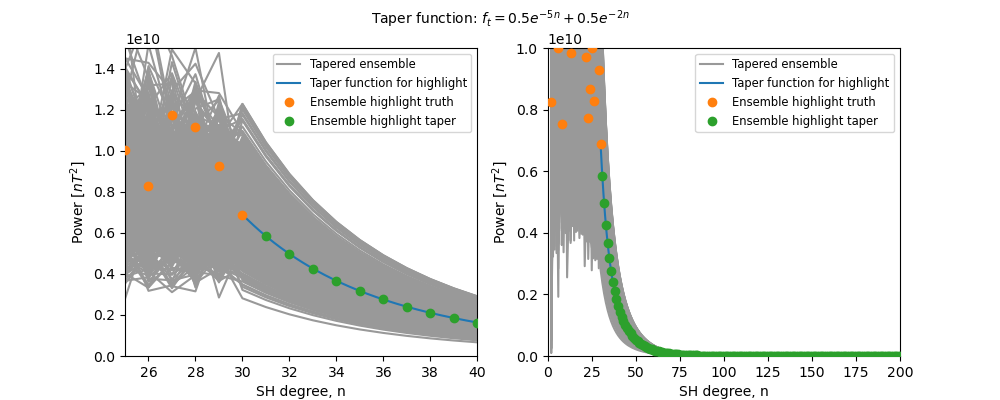

In [3]:
core.cov_model_taper(r_at = core.r_cmb, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True)

# Swarm observations through VirES VRE

In [4]:
import datetime as dt
from viresclient import SwarmRequest

request = SwarmRequest()

In [5]:
request.available_auxiliaries()

['Timestamp',
 'Latitude',
 'Longitude',
 'Radius',
 'Spacecraft',
 'OrbitDirection',
 'QDOrbitDirection',
 'SyncStatus',
 'Kp10',
 'Kp',
 'Dst',
 'F107',
 'IMF_BY_GSM',
 'IMF_BZ_GSM',
 'IMF_V',
 'F10_INDEX',
 'OrbitSource',
 'OrbitNumber',
 'AscendingNodeTime',
 'AscendingNodeLongitude',
 'QDLat',
 'QDLon',
 'QDBasis',
 'MLT',
 'SunDeclination',
 'SunHourAngle',
 'SunRightAscension',
 'SunAzimuthAngle',
 'SunZenithAngle',
 'SunLongitude',
 'SunVector',
 'DipoleAxisVector',
 'NGPLatitude',
 'NGPLongitude',
 'DipoleTiltAngle']

In [6]:
request.available_models(details=False)

['IGRF',
 'LCS-1',
 'MF7',
 'CHAOS-Core',
 'CHAOS-Static',
 'CHAOS-MMA-Primary',
 'CHAOS-MMA-Secondary',
 'MCO_SHA_2C',
 'MCO_SHA_2D',
 'MLI_SHA_2C',
 'MLI_SHA_2D',
 'MLI_SHA_2E',
 'MMA_SHA_2C-Primary',
 'MMA_SHA_2C-Secondary',
 'MMA_SHA_2F-Primary',
 'MMA_SHA_2F-Secondary',
 'MIO_SHA_2C-Primary',
 'MIO_SHA_2C-Secondary',
 'MIO_SHA_2D-Primary',
 'MIO_SHA_2D-Secondary',
 'AMPS',
 'MCO_SHA_2X',
 'CHAOS',
 'CHAOS-MMA',
 'MMA_SHA_2C',
 'MMA_SHA_2F',
 'MIO_SHA_2C',
 'MIO_SHA_2D',
 'SwarmCI']

In [7]:
collect = "SW_OPER_MAGA_LR_1B"
use_meas = ["B_NEC"]
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst", "IMF_BZ_GSM"]

use_models = ["LCS1='LCS-1'(min_degree=1, max_degree=185)", "CHAOS-MMA", "MIO_SHA_2C"] # "CHAOS='CHAOS-Core'(min_degree=15, max_degree=20)"

In [14]:
request.set_collection(collect)

request.set_products(measurements=use_meas,
                     models = use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step="PT5M") # could be reduced

date_start = [2018,8,1]
date_end = [2018,11,1]
data = request.get_between(start_time=dt.datetime(date_start[0],date_start[1],date_start[2]),
                           end_time=dt.datetime(date_end[0],date_end[1],date_end[2])) # Above 3 months could lead to secular variation "error"

ds = data.as_xarray()

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:53, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (4.543MB)


In [15]:
SZA_angle = 110
Kp_max = 2
dDst_dt_max = 2
Dst_abs_max = 30
QDlat_max = 90
IMF_BZ_min = 0.0

dDst_dt = (abs(np.diff(ds.Dst.values,prepend=0))/5)*60 #(nT/5min)/5 * 60min/hr -> nT/hr
Dst_abs = abs(ds.Dst.values)

idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, 
                                  ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, 
                                  dDst_dt<=dDst_dt_max, Dst_abs < Dst_abs_max,
                                  ds.IMF_BZ_GSM>IMF_BZ_min))

In [16]:
obs_sat = SDSS(comment, N_SH = shc_g)

M_use = ds["B_NEC_LCS1"].values[:,2][idx_sort] + ds["B_NEC_CHAOS-MMA"].values[:,2][idx_sort] #+ ds["B_NEC_MIO_SHA_2C"].values[:,2][idx_sort]  
# + ds["B_NEC_CHAOS"].values[:,2][idx_sort] 

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] + M_use

obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.data)
print(obs_sat.grid_N)

2638


In [17]:
# chaosmagpy
N_chaos = 20
CHAOS7 = load_CHAOS_matfile('mikkel_tools/models_shc/CHAOS-7.mat')
# Start
chaos_time = mjd2000(date_start[0],date_start[1],date_start[2])
g_CHAOS7 = CHAOS7.synth_coeffs_tdep(chaos_time, nmax=20, deriv=0)
A_r, A_theta, A_phi = gt.design_SHA(obs_sat.r_grid/core.a, (90-obs_sat.lat)*core.rad, obs_sat.lon*core.rad, N_chaos)
B_CHAOS7_start = np.matmul(A_r,g_CHAOS7)
# End
chaos_time = mjd2000(date_end[0],date_end[1],date_end[2])
g_CHAOS7 = CHAOS7.synth_coeffs_tdep(chaos_time, nmax=20, deriv=0)
A_r, A_theta, A_phi = gt.design_SHA(obs_sat.r_grid/core.a, (90-obs_sat.lat)*core.rad, obs_sat.lon*core.rad, N_chaos)
B_CHAOS7_end = np.matmul(A_r,g_CHAOS7)


In [18]:
B_delta_SV = B_CHAOS7_end - B_CHAOS7_start
obs_sat.data -= B_delta_SV

<IPython.core.display.Javascript object>


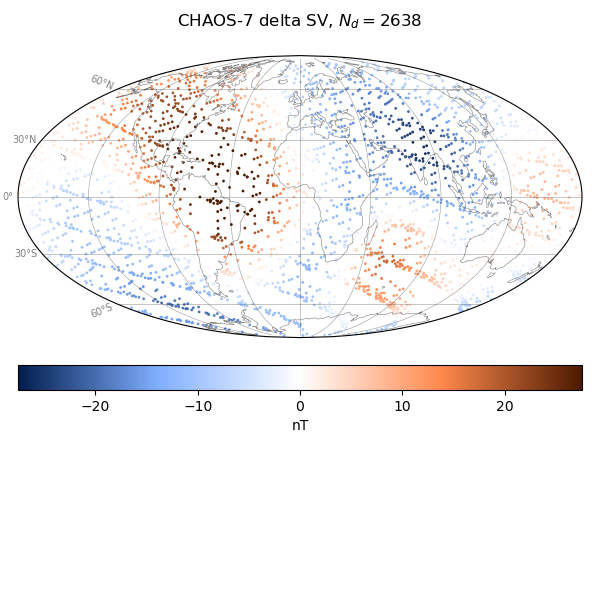

In [19]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=B_delta_SV, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7 delta SV, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


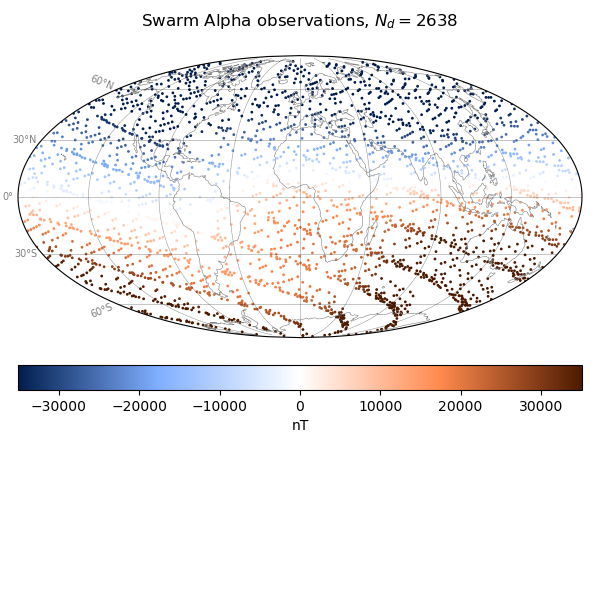

<IPython.core.display.Javascript object>


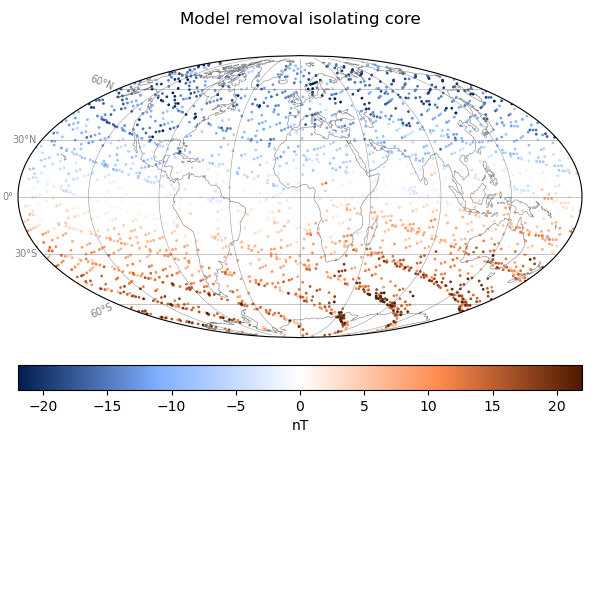

<IPython.core.display.Javascript object>


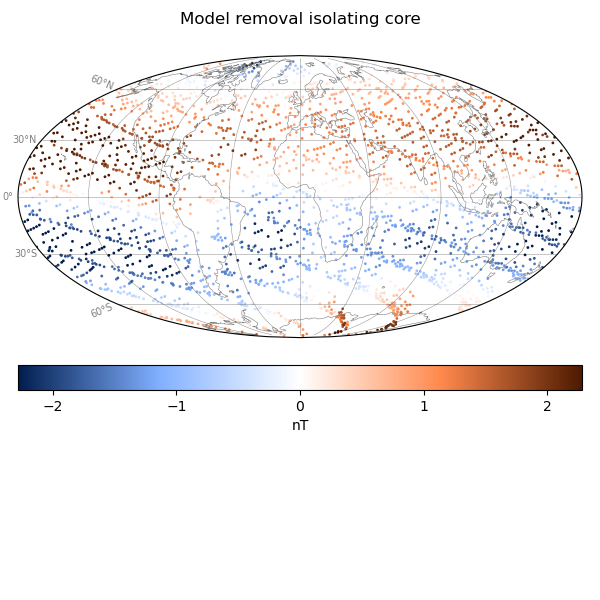

In [20]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=obs_sat.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Swarm Alpha observations, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=-M_use, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Model removal isolating core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=-ds["B_NEC_MIO_SHA_2C"].values[:,2][idx_sort], 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Model removal isolating core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# System equations

In [21]:

C_e_const = 2.0
core.integrating_kernel(obs_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)

# SDSSIM

In [ ]:
N_sim = 4
core.target_var = np.max(core.C_ens_tap)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        obs_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

 |----------| 3.0%   realization nr. 0. Counter: 57/1891, Running error magnitude: 5.9

In [112]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [113]:
#core.covmod_lsq_equiv(s_sat.data, C_Br_model, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


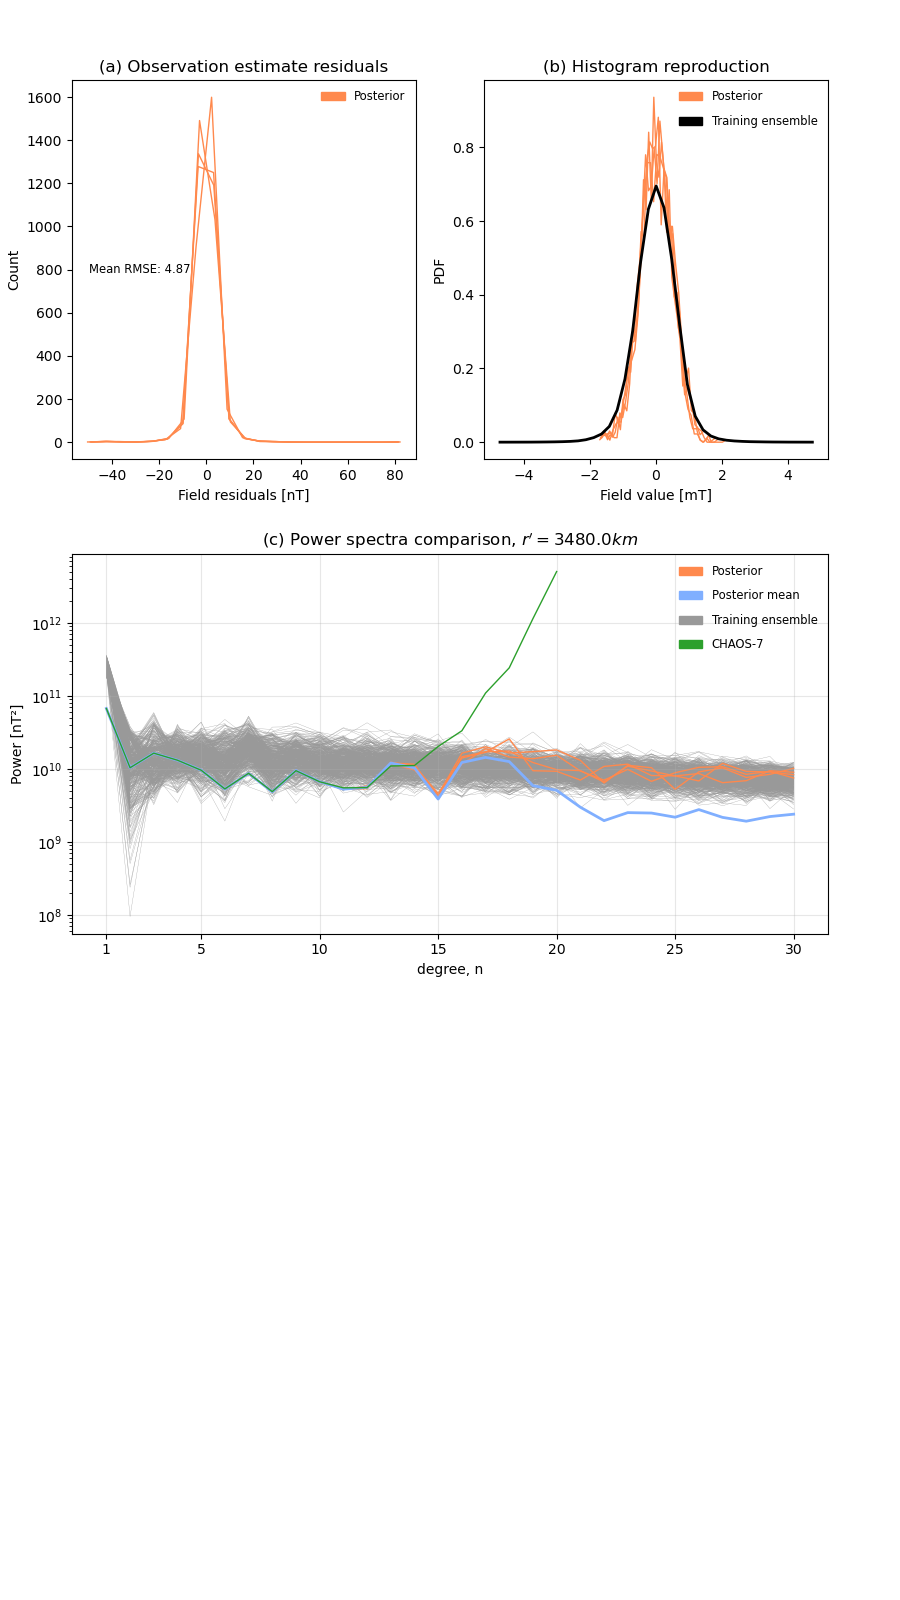

In [114]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = 1.0, label_fontsize = "small", ens_prior = True,
                              model_dict = {"CHAOS-7"}, spec_chaos_time = [2019,4,1],
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True,
                              figsize=(9,16), hist_ti_ens = True, hist_density = True,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_vires_swarm_obs", save_dpi = 300)

In [17]:
#core.pickle_save_self(nb_name)


Saving job

Job saved and finished


In [102]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)
#core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


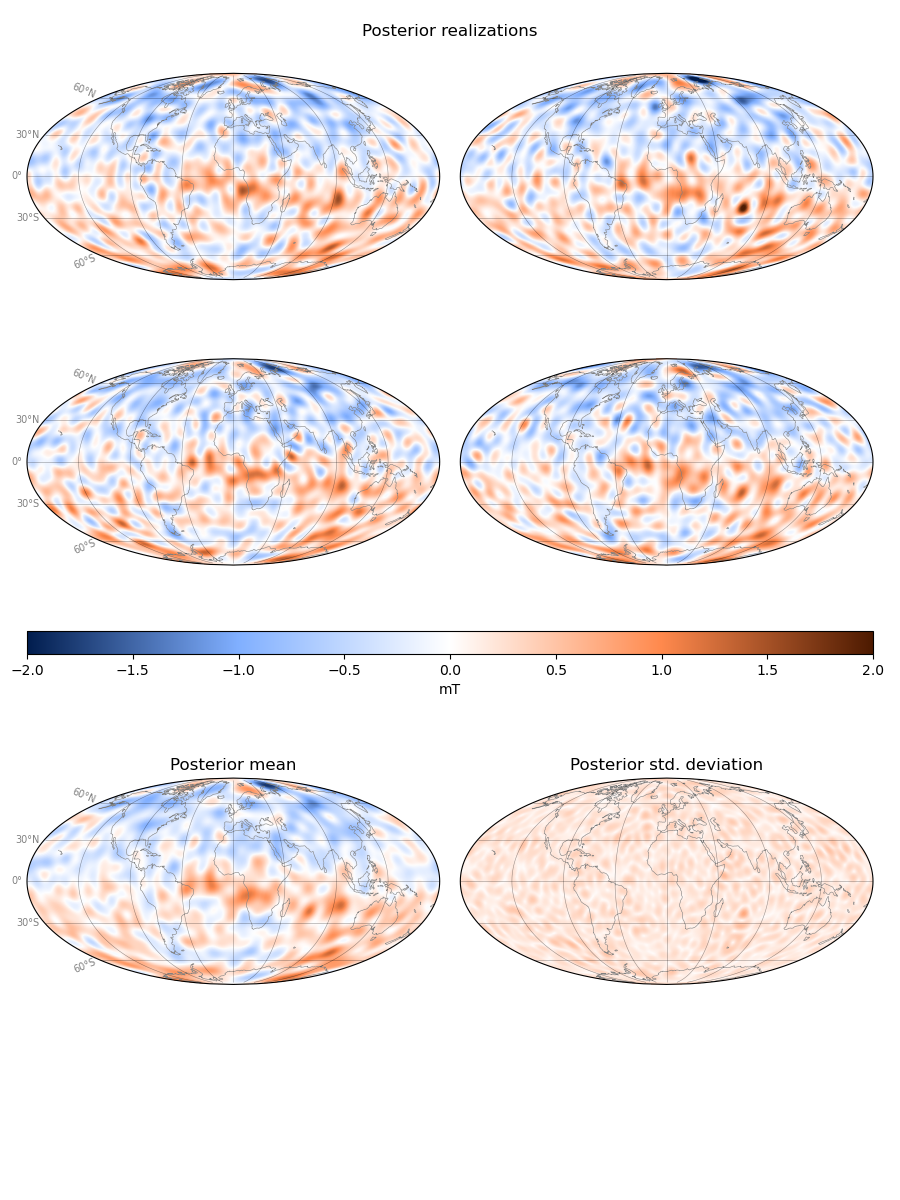

In [103]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = None, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1, cbar_limit = [-2,2],
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_vires_swarm_obs", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
